In [8]:
def convert_path(path):
    """
    Convert a file path with backslashes to forward slashes.
    """
    return path.replace('\\', '/')

# Example usage
original_path = input("Enter the folder path with backslashes: ")

directory = convert_path(original_path)

print("Converted Path:", directory)


Converted Path: G:/PIV_compare/Bubble_Seep/01082024_Pylon_RaspPi_Cam


velocity shape: (471,)
file is  velocity_field_removing_bubble_2024-01-08 16-10.mat
velocity shape: (471,)
file is  velocity_field_removing_bubble_2024-01-08 16-13.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16-14.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16-17.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16-19.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16-22.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16-23.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16-25.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16-27.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16-28.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16-30.mat
velocity shape: (472,)
file is  velocity_field_removing_bubble_2024-01-08 16

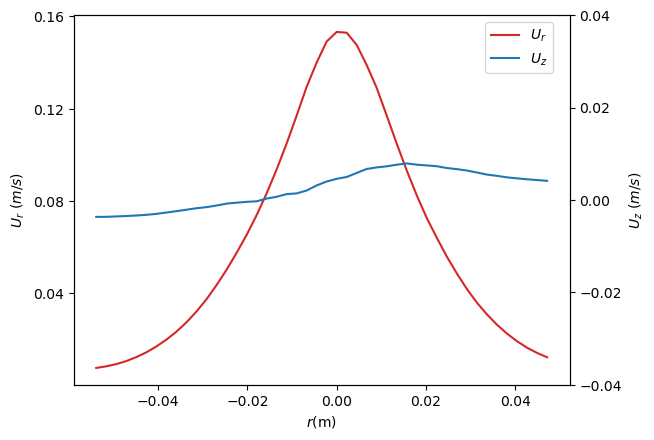

In [12]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import MaxNLocator


"""
 u = velocity in z direction U_z
 v = velocity in x direction U_r
"""

# Global variable for the main path
# MAIN_PATH = 'G:/PIV_compare/Bubble_Seep/01082024_Pylon_RaspPi_Cam'

MAIN_PATH = directory + '/'

def read_filenames(folder_name):
    """
    Reads all filenames in the specified folder.
a
    :param folder_name: Name of the folder within the main path.
    :return: List of file names.
    """
    folder_path = os.path.join(MAIN_PATH, folder_name)
    filenames = []

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return filenames

    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            filenames.append(file)

    return filenames

def check_folder(folder_name):
    """
    Creates a 'figures' folder in the main directory if it doesn't exist.
    """
    folder_path = os.path.join(MAIN_PATH, folder_name)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: '{folder_name}' at {folder_path}")
    else:
        print(f"Folder '{folder_name}' already exists at: {folder_path}")


def process_velocity(data, file_name, correlation_threshold=0.7):
    """
    Processes velocity data and generates plots.

    :param data: Dataset containing 'vel' and 'yphy' variables.
    :param file_name: Name for the output plot files.
    :param correlation_threshold: Threshold for filtering data (default 0.7).
    :return: Tuple of mean velocity arrays (U_mean, V_mean).
    """

    # Read data
    velocity = data['vel'][0]
    print("velocity shape:", velocity.shape)
    y_phy = data['yphy']

    u_components, v_components = [], []

    # Data clean

    for vel in velocity:
        u, v, c = vel['u'], vel['v'], vel['c']
        # print("u shape:", u.shape, "v shape:", v.shape)
            # Skip if u or v is empty
        if u.size == 0 or v.size == 0:
            continue
        mask = c < correlation_threshold
        u[mask] = np.nan
        v[mask] = np.nan
        u_components.append(u)
        v_components.append(v)
        

    u_stack = np.dstack(u_components) if u_components else np.array([])
    v_stack = np.dstack(v_components) if v_components else np.array([])

    if u_stack.size > 0 and v_stack.size > 0:
        u_mean, v_mean = np.nanmean(u_stack, axis=2), np.nanmean(v_stack, axis=2)
        #save_velocity_plots(u_mean, v_mean, y_phy, file_name)
        return np.nanmean(u_mean, axis=0), np.nanmean(v_mean, axis=0)
    else:
        print("No valid data to process.")
        return np.array([]), np.array([])

def save_velocity_plots(u_mean, v_mean, y_phy, file_name):
    """
    Saves plots of velocity data.

    :param u_mean: Mean U component of velocity.
    :param v_mean: Mean V component of velocity.
    :param y_phy: Physical Y coordinate array.
    :param file_name: Base name for the output files.
    """
    plt.figure()
    plt.title(f"Mean U Velocity - {file_name}")
    plt.imshow(-u_mean, cmap='rainbow')
    plt.colorbar()
    plt.savefig(f"figures/U_{file_name}.png")
    plt.close()

    plt.figure()
    plt.title(f"Mean V Velocity - {file_name}")
    plt.imshow(-v_mean, cmap='rainbow')
    plt.colorbar()
    plt.savefig(f"figures/V_{file_name}.png")
    plt.close()

def plot_aggregate_velocity(u_means, v_means, y_phy):
    """
    Plots aggregate velocity data.

    :param u_means: Array of mean U components.
    :param v_means: Array of mean V components.
    :param y_phy: Physical Y coordinate array.
    """
    check_folder('figures')
    
    if u_means.size > 0 and v_means.size > 0:

        max_index = np.argmax(-v_means)
        y_phy_max = y_phy[max_index]
        y = y_phy - y_phy_max
        fig, ax1 = plt.subplots()
        # Plot Mean U Velocity
        color_u = 'tab:red'
        ax1.set_xlabel('$r $(m)')
        ax1.set_ylabel('$U_r \ (m/s)$')
        line1, = ax1.plot(y, -v_means, color=color_u, label='$U_r$')
        ax1.tick_params(axis='y')
        ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Reduce number of x-axis ticks
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Reduce number of y-axis ticks

        # Create a second y-axis for Mean V Velocity
        ax2 = ax1.twinx()  
        color_v = 'tab:blue'
        ax2.set_ylabel('$U_z \ (m/s)$') 
        line2, = ax2.plot(y, -u_means, color=color_v, label='$U_z$')
        ax2.tick_params(axis='y')
        ax2.set_ylim(-0.04, 0.04)
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Reduce number of y-axis ticks for ax2


        # Title and legend
        # plt.title("Aggregate Mean U and V Velocities")
        # Combined legend
        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, bbox_to_anchor=(0.98, 1))


        # Save the figure
        plt.savefig(MAIN_PATH+'figures/UV.png')
        plt.show()

        plt.close()
    else:
        print("No valid data to plot.")

folder_path = MAIN_PATH + 'data'
file_list = read_filenames(folder_path)


u_means = []
v_means = []

for file_name in file_list:
    data = sio.loadmat(os.path.join(folder_path, file_name))
    u_mean, v_mean = process_velocity(data, file_name)
    print("file is ",file_name)
    if u_mean.size > 0 and v_mean.size > 0:
        u_means.append(u_mean)
        v_means.append(v_mean)


# Convert lists to NumPy arrays
u_means = np.array(u_means)
v_means = np.array(v_means)
#print("u_means shape:", u_means.shape)
#print("v_means shape:", v_means.shape)

u_means_col = np.mean(u_means, axis=0)
v_means_col = np.mean(v_means, axis=0)
y_phy = data['yphy']
#print("u_means_col shape:", u_means_col.shape)
#print("v_means_col shape:", v_means_col.shape)
#print("y_phy shape:", y_phy.shape)
y_phy = y_phy.reshape(-1)
plot_aggregate_velocity(u_means_col, v_means_col, y_phy)


